## Задача 5.1.1

In [ ]:
import math
import re
from typing import Dict, Any
from inspect import getsource
import numpy as np
import torch
from torch.nn.functional import mse_loss
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
import torch.nn.utils as utils
from inspect import getsource

In [ ]:
# Устанавливаем seed для воспроизводимости
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Python
class PurePythonForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = [1.0] * n_features
        self.b = 1.0

    def forward(
        self,
        X: list[list[float]]
    ) -> list[float]:
        """
        out_i = sum(X_i_j * w_j for j in range(n_features)) + b
        """
        out = []
        for i in range(len(X)):
            sample_out = 0.0
            for j in range(self.n_features):
                sample_out += X[i][j] * self.w[j]
            out.append(sample_out + self.b)
        return out

    def forward_and_backward(
        self,
        X: list[list[float]],
        y: list[float]
    ) -> tuple[float, list[float], float]:

        out = self.forward(X)
        n_samples = len(X)

        # Вычисляем MSE Loss
        diffs = [(out[i] - y[i]) for i in range(n_samples)]
        mse = sum([d**2 for d in diffs]) / n_samples

        # 2. Вычисляем градиенты
        grad_w = [0.0] * self.n_features
        grad_b = 0.0
        common_factor = 2.0 / n_samples

        for i in range(n_samples):
            grad_b += diffs[i]

            for j in range(self.n_features):
                grad_w[j] += diffs[i] * X[i][j]

        grad_w = [g * common_factor for g in grad_w]
        grad_b = grad_b * common_factor

        return mse, grad_w, grad_b

# NumPy
class NumPyForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = np.ones(n_features, dtype=np.float64)
        self.b = 1.0

    def forward(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        """
        out = X @ w + b
        """
        out = X @ self.w + self.b
        return out

    def forward_and_backward(
        self,
        X: np.ndarray,
        y: np.ndarray
    ) -> tuple[float, np.ndarray, float]:

        out = self.forward(X)
        n_samples = X.shape[0]

        # Вычисляем MSE Loss
        diffs = out - y # (n_samples,)
        mse = np.mean(diffs**2)

        # 2. Вычисляем градиенты
        common_factor = 2.0 / n_samples
        grad_w = (X.T @ diffs) * common_factor
        grad_b = np.sum(diffs) * common_factor

        return mse, grad_w, float(grad_b)

# PyTorch
class PyTorchForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = torch.ones(n_features, dtype=torch.float32, requires_grad=True)
        self.b = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)

    def forward(
        self,
        X: torch.Tensor,
    ) -> torch.Tensor:
        """
        out = X @ w + b
        """
        out = X @ self.w + self.b
        return out

    def forward_and_backward(
        self,
        X: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple[float, torch.Tensor, torch.Tensor]:

        out = self.forward(X)

        # Вычисляем MSE Loss
        mse = mse_loss(out, y)
        mse.backward()

        # Получаем градиенты
        grad_w = self.w.grad.clone()
        grad_b = self.b.grad.clone()

        # Обнуление градиентов
        self.w.grad.zero_()
        self.b.grad.zero_()
        return mse.item(), grad_w, grad_b

## Задача 5.1.2

In [ ]:
N_SAMPLES = 1000
N_FEATURES = 100
N_SIMULATIONS = 1000

def generate_datasets(n_samples: int, n_features: int) -> tuple:
    """
    Генерирует одинаковый набор данных для трех реализаций.
    X - нормальное распределение, y - простое линейное преобразование.
    """
    # Создаем базовые данные NumPy для воспроизводимости
    X_base = np.random.randn(n_samples, n_features).astype(np.float64)
    y_base = X_base.sum(axis=1) + 1.0

    # Python
    X_py = X_base.tolist()
    y_py = y_base.tolist()

    # NumPy
    X_np = X_base
    y_np = y_base

    # PyTorch
    X_torch = torch.from_numpy(X_base).float()
    y_torch = torch.from_numpy(y_base).float()

    # Создаем экземпляры классов для сравнения
    model_py = PurePythonForwardBackwardPass(n_features)
    model_np = NumPyForwardBackwardPass(n_features)
    model_torch = PyTorchForwardBackwardPass(n_features)

    return (
        (model_py, X_py, y_py),
        (model_np, X_np, y_np),
        (model_torch, X_torch, y_torch)
    )

# Генерируем данные один раз
DATASETS = generate_datasets(N_SAMPLES, N_FEATURES)

In [ ]:
def measure_execution_time(datasets: tuple) -> dict[str, dict[str, float]]:
    """
    Измеряет время выполнения forward и forward_and_backward для всех трех реализаций.
    """
    results = {}

    for model_data in datasets:
        model, X, y = model_data
        name = model.__class__.__name__
        results[name] = {}

        # Измерение времени forward
        start_time_f = time.perf_counter()
        _ = model.forward(X)
        end_time_f = time.perf_counter()
        results[name]['forward'] = end_time_f - start_time_f

        # Измерение времени forward_and_backward
        start_time_b = time.perf_counter()
        _ = model.forward_and_backward(X, y)
        end_time_b = time.perf_counter()
        results[name]['forward_and_backward'] = end_time_b - start_time_b

    return results

def run_simulations_and_average(n_simulations: int, datasets: tuple) -> dict[str, dict[str, float]]:
    # Инициализация словарей для суммирования времен
    total_times = {
        'PurePythonForwardBackwardPass': {'forward': 0.0, 'forward_and_backward': 0.0},
        'NumPyForwardBackwardPass': {'forward': 0.0, 'forward_and_backward': 0.0},
        'PyTorchForwardBackwardPass': {'forward': 0.0, 'forward_and_backward': 0.0},
    }

    # Запуск симуляций
    for _ in range(n_simulations):
        current_times = measure_execution_time(datasets)
        for model_name, times in current_times.items():
            total_times[model_name]['forward'] += times['forward']
            total_times[model_name]['forward_and_backward'] += times['forward_and_backward']

    # Усреднение результатов
    avg_times = {}
    for model_name, totals in total_times.items():
        avg_times[model_name] = {
            'forward': totals['forward'] / n_simulations,
            'forward_and_backward': totals['forward_and_backward'] / n_simulations,
        }

    return avg_times

Усредненное время выполнения (сек) за 1000 симуляций
| PurePythonForwardBackwardPass:
|   Forward: 0.005689
|   Forward & Backward: 0.012722
| NumPyForwardBackwardPass:
|   Forward: 0.000127
|   Forward & Backward: 0.000183
| PyTorchForwardBackwardPass:
|   Forward: 0.000176
|   Forward & Backward: 0.000489
------------------------------------------------------------------


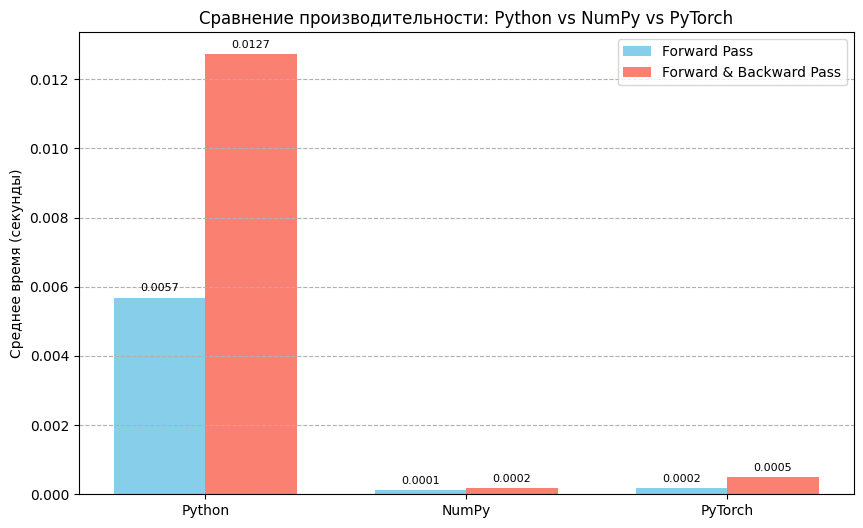

In [ ]:
# Выполнение симуляции и получение усредненных результатов
avg_results = run_simulations_and_average(N_SIMULATIONS, DATASETS)

print("Усредненное время выполнения (сек) за 1000 симуляций")
for model_name, times in avg_results.items():
    print(f"| {model_name}:")
    print(f"|   Forward: {times['forward']:.6f}")
    print(f"|   Forward & Backward: {times['forward_and_backward']:.6f}")
print("------------------------------------------------------------------")

models = list(avg_results.keys())
forward_times = [avg_results[m]['forward'] for m in models]
backward_times = [avg_results[m]['forward_and_backward'] for m in models]

# Визуализация сравнения
labels = ['Python', 'NumPy', 'PyTorch']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, forward_times, width, label='Forward Pass', color='skyblue')
rects2 = ax.bar(x + width/2, backward_times, width, label='Forward & Backward Pass', color='salmon')

ax.set_ylabel('Среднее время (секунды)')
ax.set_title('Сравнение производительности: Python vs NumPy vs PyTorch')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.show()

# Вывод
**Pure Python** - Самая медленная реализация из-за циклов и неоптимизированных списков. Ее время выполнения на порядки выше, чем у других
**NumPy** - Значительное ускорение по сравнению с чистым Python за счет векторизованных операций. Это делает NumPy в сотни раз быстрее для матричных операций
**PyTorch** - Самая быстрая реализация. PyTorch использует оптимизированные C++/CUDA бэкенды для тензорных операций, что превосходит производительность NumPy. Главное преимущество PyTorch, продемонстрированное здесь, - это автоматическое дифференцирование (`.backward()`), которое выполняет вычисления градиентов без необходимости вручную писать сложные формулы, при этом оставаясь очень быстрым. В данном примере его скорость сопоставима или немного быстрее NumPy, особенно при использовании GPU, что не было учтено в этом тесте

## Задача 5.2

In [ ]:
def halstead_metrics(code: str) -> Dict[str, float]:
    """
    Вычисляет Halstead complexity measures для заданного кода.
    """
    code = re.sub(r'#.*', '', code)
    code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    code = re.sub(r"'''.*?'''", '', code, flags=re.DOTALL)

    keywords = {
        'def', 'class', 'if', 'else', 'for', 'while', 'return', 'import',
        'from', 'as', 'with', 'in', 'not', 'and', 'or', 'is', 'True',
        'False', 'None', 'self', 'np', 'torch', 'float', 'list', 'tuple',
        'int', 'float64', 'float32', 'tensor', 'ndarray', 'clone', 'item',
        'dtype', 'requires_grad', 'sum', 'range', 'len', 'mean', 'dot',
        'shape', 'backward', 'zero_', 'optim', 'ast', 'math', 'time',
        'random', 'getsource', 'inspect', 'mse_loss', 'pd', 'array', 'dict'
    }

    operator_patterns = r'\b(def|class|if|else|for|while|return|import|from|as|with|in|not|and|or|is)\b|' \
                        r'(\*\*|\+\+|\-\-|\+=|\-=|\*=|/=|%=|@=|\/\/=|@|\(|\)|\[|\]|\{|\}|\.|,|:|;|\->|==|!=|<=|>=|\+|\-|\*|/|%|&|\||\^|~|<<|>>|=)'

    operators = [match.group(0) for match in re.finditer(operator_patterns, code) if match.group(0).strip()]


    all_tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b|\b\d+\.?\d*\b', code)
    operands = [token for token in all_tokens if token not in keywords]

    n1 = len(set(operators))
    n2 = len(set(operands))
    N1 = len(operators)
    N2 = len(operands)
    N = N1 + N2
    n = n1 + n2

    V = N * math.log2(n) if n > 1 else 0
    D = (n1 / 2.0) * (N2 / n2) if n2 > 0 else 0
    E = D * V

    return {
        'n1': n1, 'n2': n2, 'N1': N1, 'N2': N2, 'N': N,
        'V': round(V, 2), 'D': round(D, 2), 'E': round(E, 2)
    }

code_pure_orig = """
class PurePythonForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = [1.0] * n_features
        self.b = 1.0

    def forward(
        self,
        X: list[list[float]]
    ) -> list[float]:
        out = []
        for i in range(len(X)):
            sample_out = 0.0
            for j in range(self.n_features):
                sample_out += X[i][j] * self.w[j]
            out.append(sample_out + self.b)
        return out

    def forward_and_backward(
        self,
        X: list[list[float]],
        y: list[float]
    ) -> tuple[float, list[float], float]:

        out = self.forward(X)
        n_samples = len(X)
        diffs = [(out[i] - y[i]) for i in range(n_samples)]
        mse = sum([d**2 for d in diffs]) / n_samples

        grad_w = [0.0] * self.n_features
        grad_b = 0.0
        common_factor = 2.0 / n_samples

        for i in range(n_samples):
            grad_b += diffs[i]
            for j in range(self.n_features):
                grad_w[j] += diffs[i] * X[i][j]

        grad_w = [g * common_factor for g in grad_w]
        grad_b = grad_b * common_factor

        return mse, grad_w, grad_b
"""

code_numpy_orig = """
class NumPyForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = np.ones(n_features, dtype=np.float64)
        self.b = 1.0

    def forward(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        out = X @ self.w + self.b
        return out

    def forward_and_backward(
        self,
        X: np.ndarray,
        y: np.ndarray
    ) -> tuple[float, np.ndarray, float]:

        out = self.forward(X)
        n_samples = X.shape[0]
        diffs = out - y
        mse = np.mean(diffs**2)

        common_factor = 2.0 / n_samples
        grad_w = (X.T @ diffs) * common_factor
        grad_b = np.sum(diffs) * common_factor

        return mse, grad_w, float(grad_b)
"""

code_torch_orig = """
class PyTorchForwardBackwardPass:
    def __init__(self, n_features: int):
        self.n_features = n_features
        self.w = torch.ones(n_features, dtype=torch.float32, requires_grad=True)
        self.b = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)

    def forward(
        self,
        X: torch.Tensor,
    ) -> torch.Tensor:
        out = X @ self.w + self.b
        return out

    def forward_and_backward(
        self,
        X: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple[float, torch.Tensor, torch.Tensor]:

        out = self.forward(X)
        mse = mse_loss(out, y)
        mse.backward()

        grad_w = self.w.grad.clone()
        grad_b = self.b.grad.clone()

        self.w.grad.zero_()
        self.b.grad.zero_()
        return mse.item(), grad_w, grad_b
"""

# Вычисление метрик
halstead_pure = halstead_metrics(code_pure_orig)
halstead_numpy = halstead_metrics(code_numpy_orig)
halstead_torch = halstead_metrics(code_torch_orig)

dfdf = {"Pythn": halstead_pure, "Numpy": halstead_numpy, "Torch": halstead_torch}
dfdf = pd.DataFrame(dfdf)

In [ ]:
dfdf

,Pythn,Numpy,Torch
n1,20.00,18.00,14.00
n2,26.00,22.00,17.00
N1,162.00,86.00,104.00
N2,84.00,46.00,46.00
N,246.00,132.00,150.00
V,1358.80,702.49,743.13
D,32.31,18.82,18.94
E,43899.57,13219.67,14075.75


## Задача 5.3

<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-514401673.py:31: SyntaxWarning: invalid escape sequence '\i'
  plt.title('График функции потерь $L[p]$ в диапазоне $p \in [-3, 3]$')


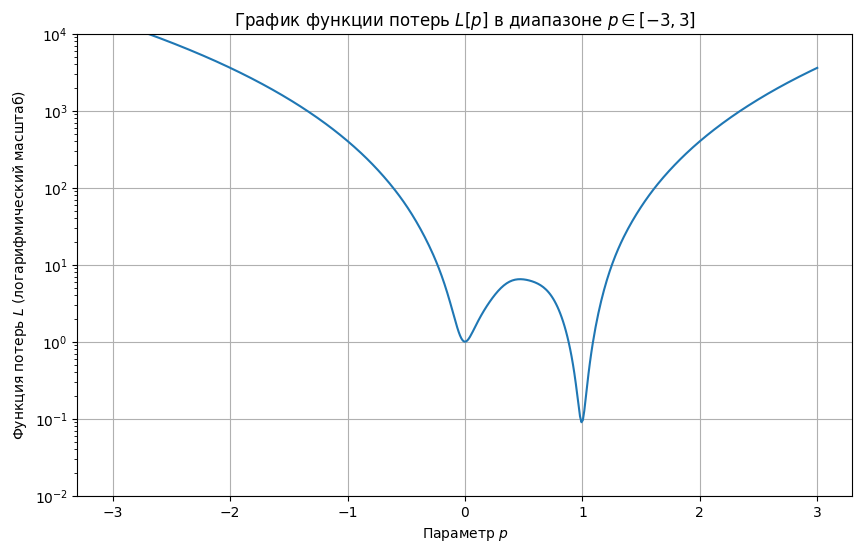

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Определение функции потерь L[p] ---
def loss_function(p: torch.Tensor) -> torch.Tensor:
    """
    Определяет функцию потерь L[p]. Принимает и возвращает torch.Tensor.
    """
    # L[p] = (1 - p)^2 + 100 * (p^2 - p)^2 + (1/10) * sin(20p)
    term1 = (1 - p)**2
    term2 = 100 * (p**2 - p)**2
    term3 = (1/10) * torch.sin(20 * p)

    return term1 + term2 + term3

# --- Построение графика ---
def plot_loss_surface():
    # Создаем 500 точек в диапазоне p ∈ [-3, 3]
    p_values = torch.linspace(-3.0, 3.0, 500)

    # Вычисляем значения L[p] без необходимости вычисления градиентов (torch.no_grad())
    with torch.no_grad():
        L_values = loss_function(p_values)

    plt.figure(figsize=(10, 6))

    # Используем numpy() для конвертации тензоров в массивы, пригодные для Matplotlib
    plt.plot(p_values.numpy(), L_values.numpy())

    plt.title('График функции потерь $L[p]$ в диапазоне $p \in [-3, 3]$')
    plt.xlabel('Параметр $p$')
    plt.ylabel('Функция потерь $L$ (логарифмический масштаб)')

    # Применяем логарифмический масштаб по вертикальной оси L
    plt.yscale('log')
    plt.grid(True)

    # Ограничиваем ось Y, чтобы избежать слишком больших значений,
    # которые могут возникнуть из-за квадратичных членов
    plt.ylim(1e-2, 1e4)

    plt.show()

# Запуск функции построения
plot_loss_surface()

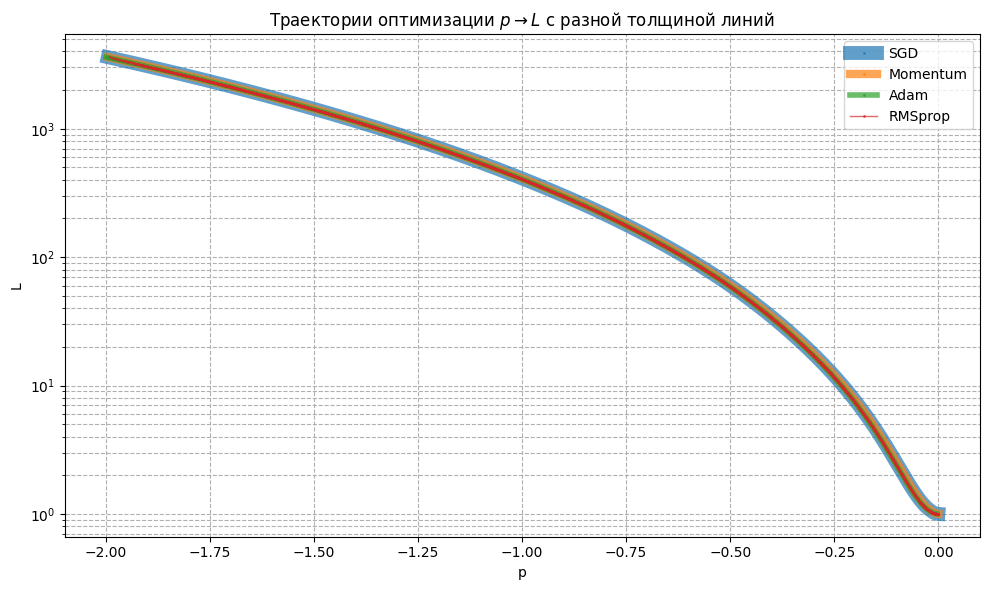

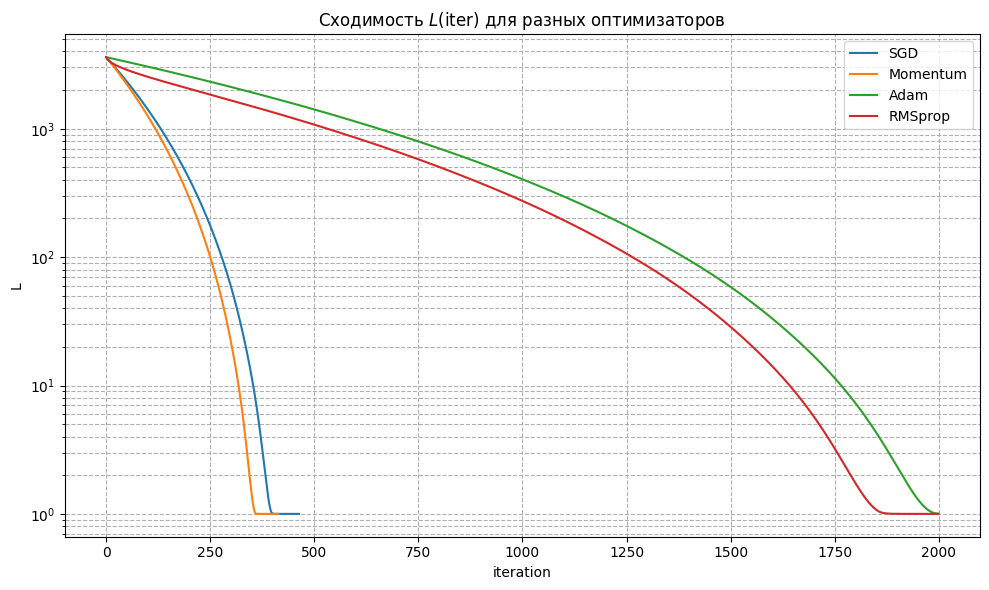

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Установка device
device = torch.device("cuda")

# Определение функции потерь L[p]
def loss_function(p: torch.Tensor) -> torch.Tensor:
    """
    Определяет функцию потерь L[p] = (1 - p)^2 + 100 * (p^2 - p)^2 + 1/10 * sin(20p).
    """
    term1 = (1 - p)**2
    term2 = 100 * (p**2 - p)**2
    term3 = (1/10) * torch.sin(20 * p)

    return term1 + term2 + term3

# Функция градиентного спуска с модифицированным условием остановки ---
def run_optimization(initial_p: float, learning_rate: float, n_iterations: int, momentum_param: float = 0.1):
    optim_data = {
        'SGD': {'optimizer_class': optim.SGD, 'params': {'lr': learning_rate}},
        'Momentum': {'optimizer_class': optim.SGD, 'params': {'lr': learning_rate, 'momentum': momentum_param}},
        'Adam': {'optimizer_class': optim.Adam, 'params': {'lr': learning_rate}},
        'RMSprop': {'optimizer_class': optim.RMSprop, 'params': {'lr': learning_rate}, 'alpha': 0.9},
    }

    logged_data = {}

    for name, config in optim_data.items():
        p = torch.tensor([initial_p], dtype=torch.float32, device=device, requires_grad=True)

        optimizer = config['optimizer_class']([p], **config['params'])

        p_history = []
        L_history = []

        # Основной цикл градиентного спуска
        for i in range(n_iterations):
            if not torch.isfinite(p).all():
                break

            optimizer.zero_grad()
            L = loss_function(p)

            L.backward()
            utils.clip_grad_norm_([p], max_norm=5.0)
            optimizer.step()

            p_history.append(p.item())
            L_history.append(L.item())

            if name != 'RMSprop':
                if p.grad is not None and torch.abs(p.grad).item() < 1e-6 and L.item() < 100:
                    break

        logged_data[name] = {'p': np.array(p_history), 'L': np.array(L_history)}

    return logged_data

# Настройка и запуск оптимизации
initial_p = -2.0
LEARNING_RATE = 0.001
N_ITERATIONS = 2000

# Запуск оптимизации
data = run_optimization(
    initial_p=initial_p,
    learning_rate=LEARNING_RATE,
    n_iterations=N_ITERATIONS
)

# Задаем разные толщины линий для каждого оптимизатора
line_widths = {
    'SGD': 10,
    'Momentum': 6,
    'Adam': 4,
    'RMSprop': 1
}

# График Траектории
plt.figure(figsize=(10, 6))
plt.title(f'Траектории оптимизации $p \\rightarrow L$ с разной толщиной линий')
plt.xlabel('p')
plt.ylabel('L')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

for name, history in data.items():
    valid_indices = history['L'] < 1e28

    p_safe = history['p'][valid_indices]
    L_safe = history['L'][valid_indices]

    lw = line_widths.get(name, 2.0)

    plt.plot(
        p_safe,
        L_safe,
        label=name,
        marker='.',
        markersize=2,
        alpha=0.7,
        linewidth=lw
    )

plt.legend()
plt.tight_layout()
plt.show()

# График Сходимости

plt.figure(figsize=(10, 6))
plt.title('Сходимость $L(\\mathrm{iter})$ для разных оптимизаторов')
plt.xlabel('iteration')
plt.ylabel('L')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

for name, history in data.items():
    L_safe = history['L']
    valid_indices = np.isfinite(L_safe) & (L_safe < 1e30)
    plt.plot(np.arange(len(L_safe))[valid_indices], L_safe[valid_indices], label=name)

plt.legend()
plt.tight_layout()
plt.show()